# Benson Project

WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. There has been a significant drop in attendance at the last WTWY Gala. This will affect the direction and efficacy of WTWY’s mission statement - that is unacceptable. 

We recently obtained NYC MTA data and would like to make a valuable contribution to increasing their overall membership rates.

Our data gives us insight into which stations and days of the week have the most foot-traffic - thus optimizing volunteer placement for outreach. Our analysis even highlights specific turnstiles within a station!

Furthermore, trends by week and time are readily available. Complimentary graphs for viewing pleasure.

Currently, we are in the process of combining census data with our findings to give further insight into the demographics of foot-traffic, that is to say, WTWY's future potential donors and members.

In [288]:
# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

import datetime
from datetime import datetime as dt
import calendar

import pickle
from copy import deepcopy

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [289]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.1
Numpy version: 1.12.1


In [290]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 3)

### Obtaining the Data

The gala will be held on May 30th! We wish to give WTWY 2 weeks to in order to implement our findings!

In order to use the latest results, we will be using MTA data that relates to 3 weeks prior to the 2 week implemtation process.

Below we will clean up/standardize the headers in addition to adding useful information to the datframe i.e. turnstile.

We will also pickle our resulting dataframe in order to ensure we can obtain the original information with speed should it be required later on.

In [ ]:
MTA_May13 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt')
MTA_May06 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170506.txt')
MTA_Apr29 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170429.txt')

MTAdata_orig = pd.concat([MTA_Apr29, MTA_May06, MTA_May13], ignore_index = True)

MTAdata_orig.rename(columns=lambda x: x.strip(), inplace=True) #rid of whitespace

In [ ]:
pickle.dump(MTAdata_orig, open("data/MTAdata_orig", "wb"))
MTAdata_orig.head(10)

In [ ]:
MTAdata = pickle.load(open("data/MTAdata_orig", "rb"))

In [ ]:
MTAdata['date'] = MTAdata['DATE'].apply(lambda x: dt.strptime(x, '%m/%d/%Y')) #make datetime objects
MTAdata['week_day_num'] = MTAdata['DATE'].apply(lambda x: pd.to_datetime(x, format = '%m/%d/%Y').weekday()) #names of the days of week
MTAdata['week_day_name'] = MTAdata['week_day_num'].apply(lambda x: dayofweek[x]) #numeric indicies that relate to day of week
MTAdata['time'] = MTAdata['TIME'].apply(lambda x: dt.strptime(x, '%H:%M:%S').time()) #makes time object
MTAdata['turnstile'] = MTAdata['C/A'] + " "+ MTAdata['SCP'] #identifies unique turnstile

In [ ]:
MTAdata.head(10)

### Interesting observation!

It seems that the entries and exits are accumalted values. Thus, we have to find the differences between subsequent entries at the **turnstile** level.

In [ ]:
#turnstile level for entries
MTAdata['turnstile entries'] = MTAdata.groupby(['turnstile'])['ENTRIES'].transform(lambda x: x.diff())

#turnstile level for exits
MTAdata['turnstile exits'] = MTAdata.groupby(['turnstile'])['EXITS'].transform(lambda x: x.diff())


In [ ]:
#the starting point of our differences will have NaN's, lets change those to 0's!
MTAdata['turnstile entries'].fillna(0, inplace=True)
MTAdata['turnstile entries'].fillna(0, inplace=True)

In [ ]:
#Some of the entry and exit numbers are negative. We assume they are due to the counter errors from the original data. 
#The rows with negative entry or exit numbers will be removed.
MTAdata = MTAdata[(MTAdata['turnstile entries'] > 0) & (MTAdata['turnstile exits'] > 0)]

In [ ]:
#the total traffic at a turnstile in a given block of time (4hrs) is the sum of entries and exits.
MTAdata['traffic'] = MTAdata[['turnstile entries', 'turnstile exits']].sum(axis=1)

In [ ]:
#since our analysis is at the turnstile level, we assume an upper bound of 5000 individuals through a turnstile
#in a block of time.
MTAdata = MTAdata[MTAdata['traffic'] <= 5000]

In [ ]:
#Save MTA dataframe locally.
pickle.dump(MTAdata, open("data/MTAdata_clean", "wb"))

In [302]:
#Load clean MTA dataframe.
MTAdata = pickle.load(open("data/MTAdata_clean", "rb"))

In [303]:
MTAdata.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,date,week_day_num,week_day_name,time,turnstile,turnstile entries,turnstile exits,traffic
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2017,04:00:00,REGULAR,6148080,2082123,2017-04-22,5,Saturday,04:00:00,A002 02-00-00,55.0,3.0,58.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2017,08:00:00,REGULAR,6148101,2082157,2017-04-22,5,Saturday,08:00:00,A002 02-00-00,21.0,34.0,55.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2017,12:00:00,REGULAR,6148224,2082251,2017-04-22,5,Saturday,12:00:00,A002 02-00-00,123.0,94.0,217.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2017,16:00:00,REGULAR,6148524,2082316,2017-04-22,5,Saturday,16:00:00,A002 02-00-00,300.0,65.0,365.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/22/2017,20:00:00,REGULAR,6148910,2082368,2017-04-22,5,Saturday,20:00:00,A002 02-00-00,386.0,52.0,438.0


In [304]:
average_traffic_per_day = int((sum(MTAdata['traffic'])/3)/7)
print("Average Traffic through turnstiles per day: ", average_traffic_per_day)

Average Traffic through turnstiles per day:  9090372


!!!Need to modify!!! From NYC MTA we obtain the following top 5 stations in the city. Get traffic data for each turnstile at each day of the week.

In [308]:
#Get the total traffic data for each day of the week.
day_total_traffic = pd.DataFrame(MTAdata.groupby(['week_day_name', 'week_day_num'])['traffic'].sum()).reset_index()

In [309]:
#Get the average traffic data for each day of the week.
day_average_traffic = deepcopy(day_total_traffic)
day_average_traffic['traffic'] = day_average_traffic['traffic'] / 3
day_average_traffic = day_average_traffic.sort_values('week_day_num')

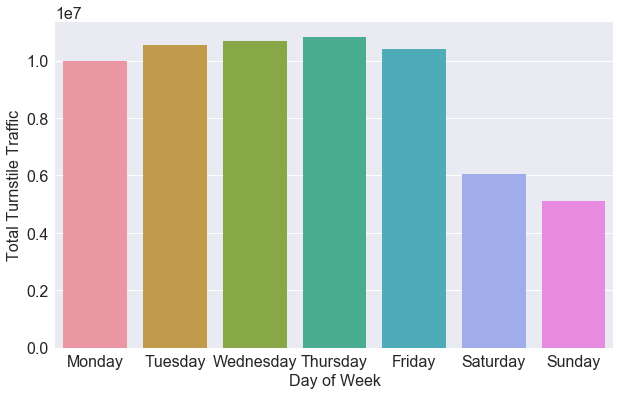

In [310]:
#plot the Average Daily Traffic on Day of Week
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 32.0, 'axes.titlesize': 24, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
sns.set(rc = rc)
sns.barplot(x = day_average_traffic['week_day_name'], y = day_average_traffic['traffic'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Turnstile Traffic');
#ax.set_title('Traffic on Day of Week for NYC MTA System')
fig.savefig("images/Traffic on Day of Week for NYC MTA System.png")

In [318]:
#Get the average daily traffic data for each station based on weekday traffic.
station_day_total_traffic = pd.DataFrame(MTAdata.groupby(['STATION'])['traffic'].sum()).reset_index()
station_day_average_traffic = deepcopy(station_day_total_traffic)
station_day_average_traffic['traffic'] = station_day_total_traffic['traffic'] / 21
station_day_average_traffic.head(5)

,STATION,traffic
0,1 AV,39624.714
1,103 ST,47577.476
2,103 ST-CORONA,31431.333
3,104 ST,2986.619
4,110 ST,19800.714


             STATION     traffic
61    34 ST-PENN STA  266657.095
232  GRD CNTRL-42 ST  230415.571
59   34 ST-HERALD SQ  198296.238
14    14 ST-UNION SQ  179309.524
349   TIMES SQ-42 ST  168519.810


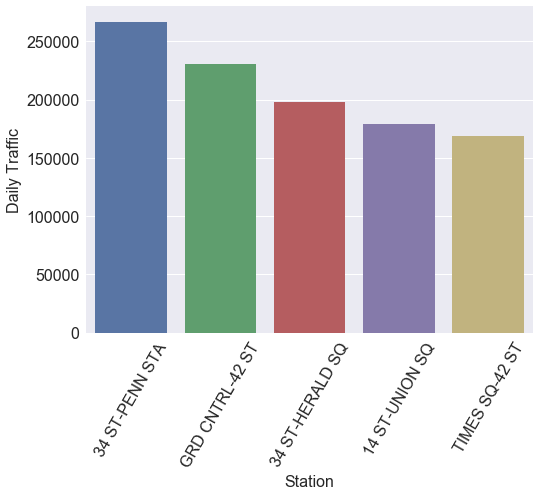

In [319]:
#plot the average daily traffic data for top stations based on weekday traffic
top_5_list = [('TIMES SQ-42 ST'), ('GRD CNTRL-42 ST'), ('34 ST-HERALD SQ'), ('14 ST-UNION SQ'), ('34 ST-PENN STA')]
top_station_day_average_traffic = station_day_average_traffic[station_day_average_traffic['STATION'].isin(top_5_list)].sort_values('traffic', ascending = False)
print(top_station_day_average_traffic)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 32.0, 'axes.titlesize': 24, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
sns.set(rc = rc)
stagraph = sns.barplot(x = top_station_day_average_traffic['STATION'] , y = top_station_day_average_traffic['traffic'])
for item in stagraph.get_xticklabels():
    item.set_rotation(60)
ax.set_xlabel('Station')
ax.set_ylabel('Daily Traffic');
#ax.set_title('Traffic on Day of Week for NYC MTA System')
fig.savefig("images/Daily Traffic for Top Stations.png")

In [315]:
def time_bin(x):
    if x < datetime.time(2):
        return "00:00-01:59"
    elif x < datetime.time(6):
        return "02:00-05:59"
    elif x < datetime.time(10):
        return "06:00-09:59"
    elif x < datetime.time(14):
        return "10:00-13:59"
    elif x < datetime.time(18):
        return "14:00-17:59"
    elif x < datetime.time(22):
        return "18:00- 21:59"
    else:
        return "22:00-23:59"
MTAdata["Time_Bin"] = MTAdata["time"].apply(time_bin)

In [316]:
time_breakdown = pd.DataFrame(MTAdata[MTAdata['STATION'].isin(top_5_list)].groupby(['STATION','Time_Bin']).sum()['traffic']).reset_index()

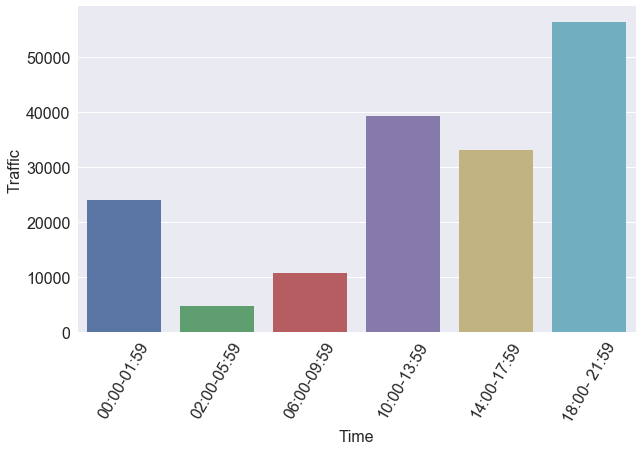

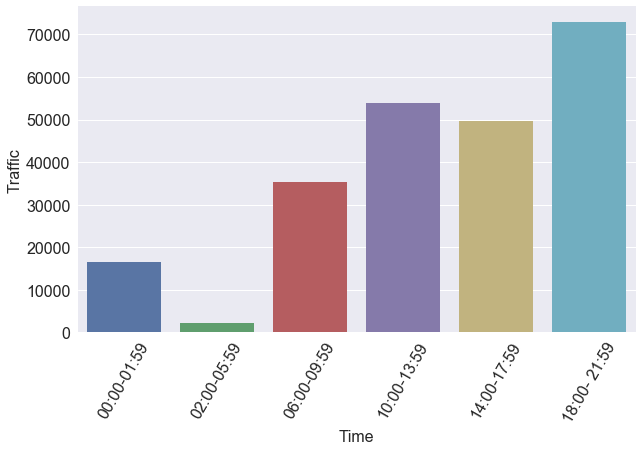

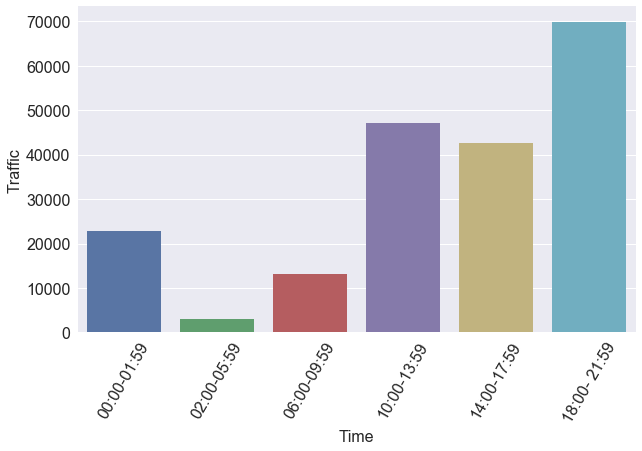

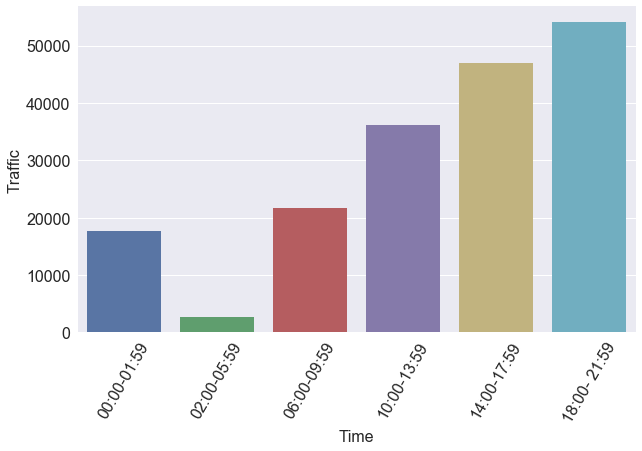

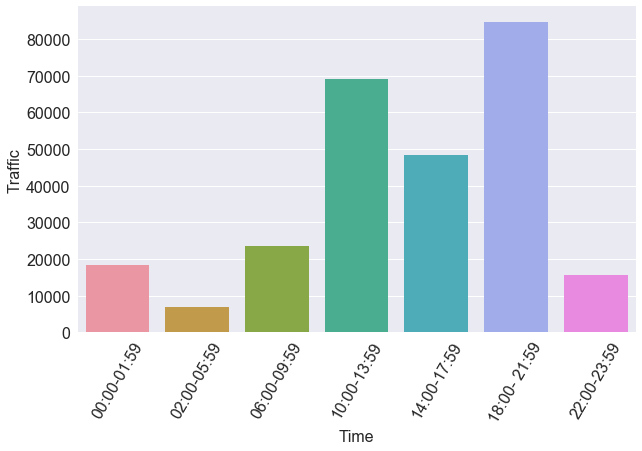

In [322]:
top_station_time_traffic = defaultdict(pd.DataFrame)
for station in top_5_list:
    top_station_time_traffic[station] = pd.DataFrame(MTAdata[MTAdata['STATION'] == station].groupby(['STATION', 'Time_Bin'])['traffic'].sum()).reset_index()
    top_station_time_traffic[station]['traffic'] = top_station_time_traffic[station]['traffic']/21
#    print(top_station_time_traffic[station].head())
    fig, ax = plt.subplots()
    fig.set_size_inches(10,6)
    graph = sns.barplot(x = top_station_time_traffic[station]['Time_Bin'], y = top_station_time_traffic[station]['traffic'])
    for item in graph.get_xticklabels():
        item.set_rotation(60)
    ax.set_xlabel('Time')
    ax.set_ylabel('Traffic')
    fig.savefig("images/Peak hours for %s.png" %station)

In [323]:
top_station_turnstile_traffic = defaultdict(pd.DataFrame)

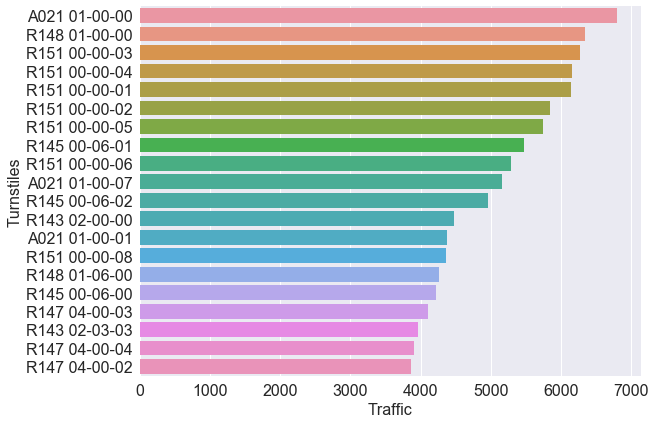

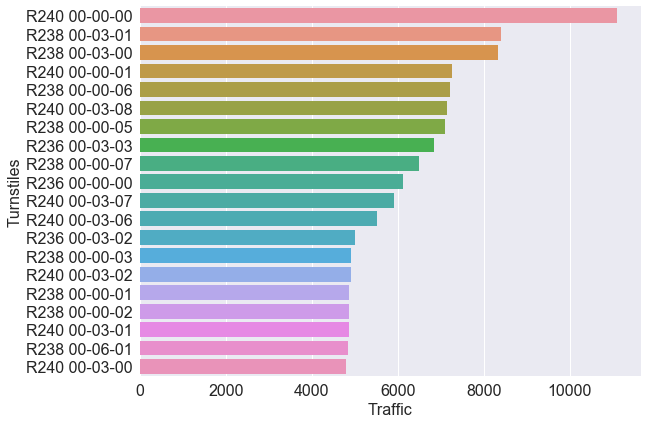

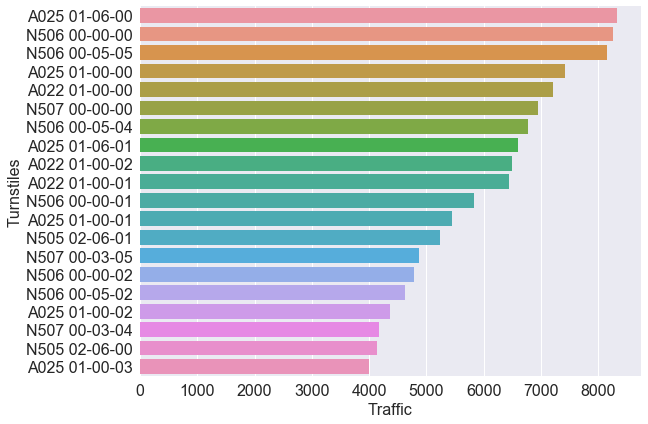

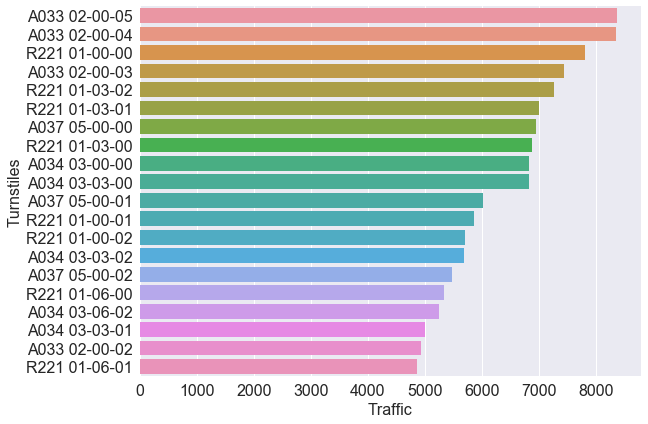

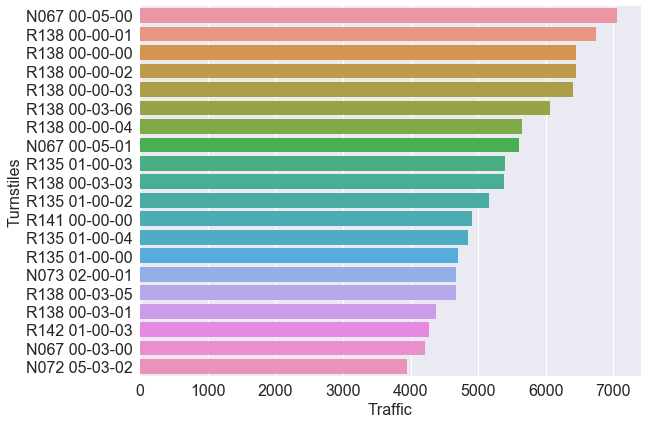

In [337]:
for station in top_5_list:
    top_station_turnstile_traffic[station] = pd.DataFrame(MTAdata[MTAdata['STATION'] == station].groupby(['turnstile'])['traffic'].sum()).reset_index()
    top_station_turnstile_traffic[station] = top_station_turnstile_traffic[station].sort_values('traffic', ascending = False).reset_index()
    top_station_turnstile_traffic[station]['traffic'] = top_station_turnstile_traffic[station]['traffic']/21
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    plt.tight_layout()
    graph = sns.barplot(y = top_station_turnstile_traffic[station]['turnstile'][:20], x = top_station_turnstile_traffic[station]['traffic'][:20])
    ax.set_xlabel('Traffic')
    ax.set_ylabel('Turnstiles')
    fig.savefig("images/Highlight Turnstiles for %s.png" %station)

In [339]:
TechCompanyHeadcount = pd.read_csv('data/TechCompanyHeadcount.csv')
TechCompanyHeadcount.rename(columns=lambda x: x.strip(), inplace=True)
TechCompanyHeadcount.columns

Index(['Company Name', 'NYC headcount:', '% of company based in NYC:',
       '% of engineers based in NYC:', 'Breakdown engineers vs non:'],
      dtype='object')

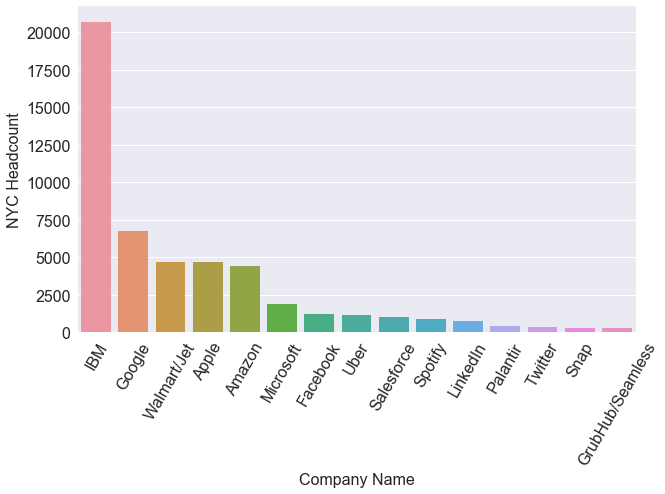

In [352]:
fig, ax = plt.subplots(figsize = (10, 6))
techgraph = sns.barplot(x = TechCompanyHeadcount['Company Name'][:15], y = TechCompanyHeadcount['NYC headcount:'][:15], ax=ax)
for item in techgraph.get_xticklabels():
    item.set_rotation(60)
ax.set_xlabel('Company Name');
ax.set_ylabel('NYC Headcount');
plt.savefig('images/NYC Tech Company Headcount.png');

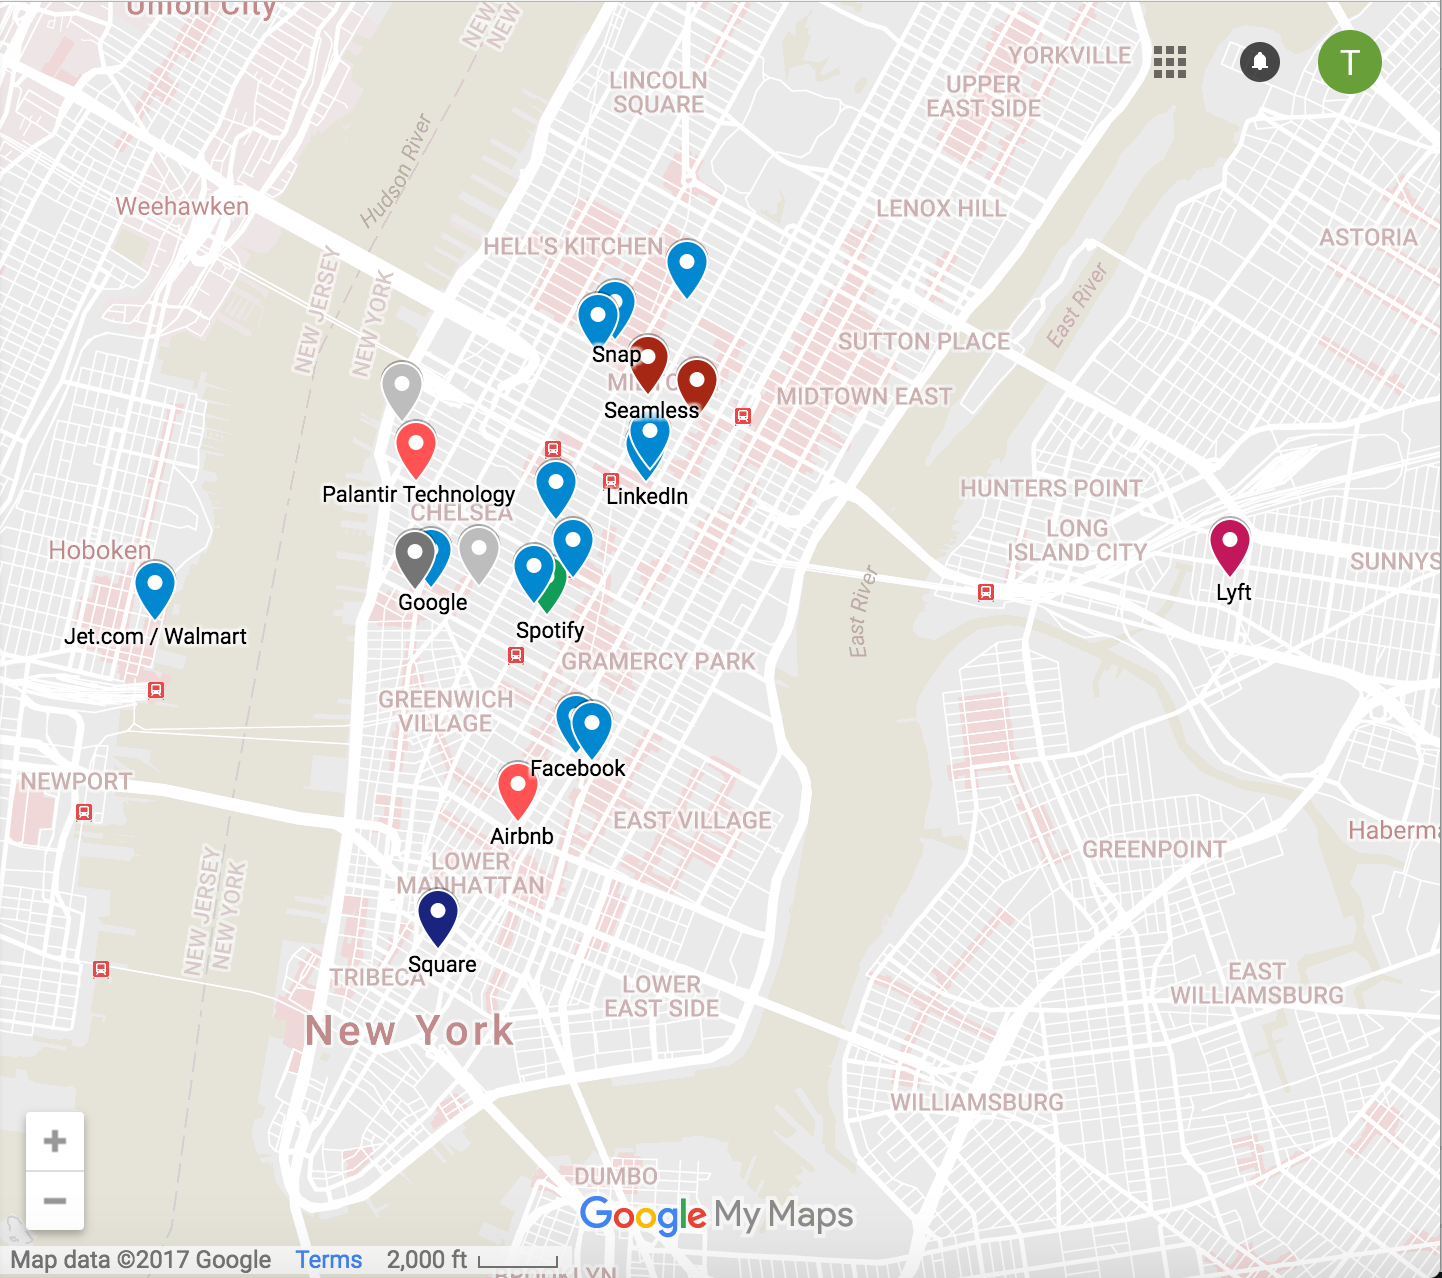

In [348]:
Image(filename='images/Tech Company Map/Tech Company Map.png')

### Demograhics

The demographic information for Time-Sq, Grand-Central, Herald-Sq and Penn-Station


Time-Sq, Grand-Central, Herald-Sq and Penn Station are all located in the same census tract. This is great news as we can aggregate demographic information for 4/5 top stations!

Below is an image of the census tract!

In [349]:
#Image('images/midtown.jpg')

Let's look at some key target demographics!

In [390]:
gender_denisty_dict = {"Female": 51.7, "Male": 48.2}

age_density_dict = {"20-24":11.5, "25-29":15.9, "30-34":11.9, "35-39": 8.6}

genderdata = pd.DataFrame.from_dict(gender_denisty_dict, orient='index')
agedata = pd.DataFrame.from_dict(age_density_dict, orient='index')

genderdata['gender'] = ['Female','Male']
agedata['age'] = ['20-24', '25-29', '30-34', '35-39']

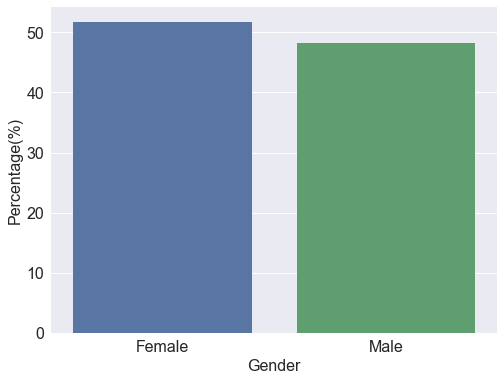

In [402]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(y = genderdata[0], x = genderdata['gender'])
ax.set_xlabel('Gender');
ax.set_ylabel('Percentage(%)');
plt.savefig('images/Gender Breakdown Midtown.png');

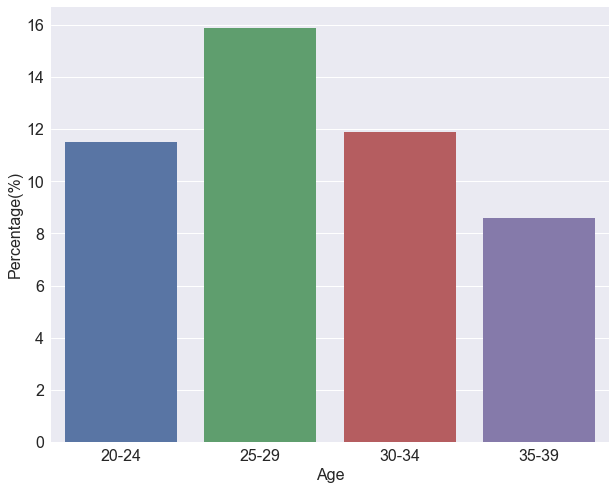

In [404]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(y = agedata[0], x = agedata['age'])
ax.set_xlabel('Age');
ax.set_ylabel('Percentage(%)');
plt.savefig('images/Age Breakdown Midtown.png');

In [397]:
midtown_demo = pd.read_csv('data/midtown_agg_demo.csv')

In [398]:
del midtown_demo['Unnamed: 3']
del midtown_demo['Unnamed: 4']
midtown_demo.dropna(inplace=True)

In [401]:
midtown_demo['Percent'] = midtown_demo['Percent'].apply(lambda x: str(x))
midtown_demo['Percent'] = midtown_demo['Percent'].apply(lambda x: float(x.strip("%")))
midtown_demo

,Race,Number,Percent
0,White nonhispanic,"18,351",64.1
1,Black/African American nonhispanic,"1,310",4.6
2,Asian nonhispanic,"5,942",20.8
3,Some other race nonhispanic,134,0.5
4,Nonhispanic of two or more races,569,2.0
5,Hispanic origin,"2,324",8.1


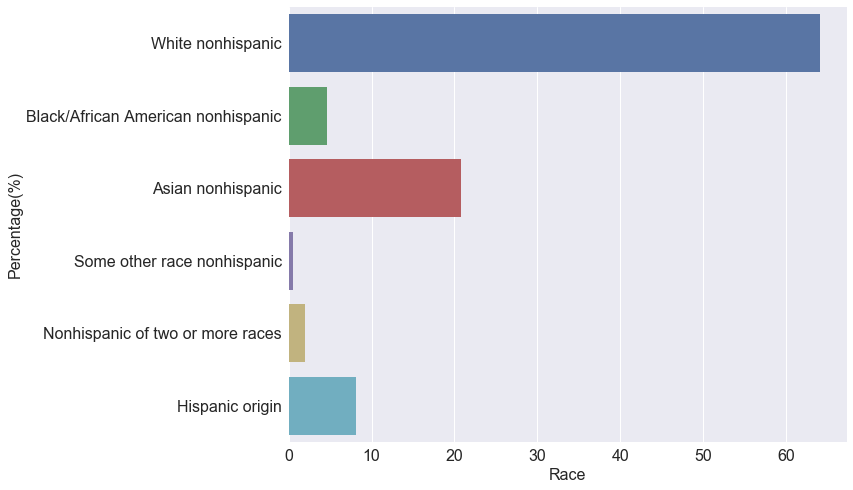

In [416]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(y = midtown_demo['Race'], x = midtown_demo['Percent'])
ax.set_xlabel('Race');
ax.set_ylabel('Percentage(%)');
plt.savefig('images/Race Breakdown Midtown.png');

In [411]:
midtown_asian_pop = pd.read_csv('data/midtown_asian_breakdown.csv')

In [420]:
midtown_asian_pop = midtown_asian_pop.sort_values('Percent', ascending = False)

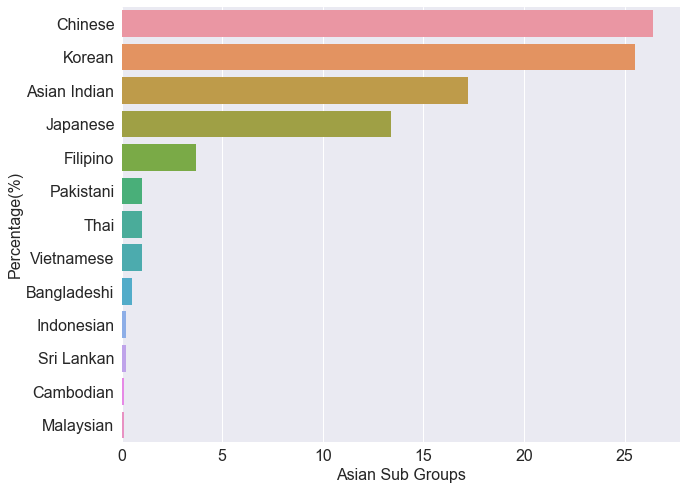

In [421]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(y = midtown_asian_pop['SELECTED ASIAN SUBGROUPS'], x = midtown_asian_pop['Percent'])
ax.set_xlabel('Asian Sub Groups');
ax.set_ylabel('Percentage(%)');
plt.savefig('images/Asian Sub Groups Breakdown Midtown.png');

In [424]:
midtown_hispanic_pop = pd.read_csv('data/midtown_hispanic_breakdown.csv')
midtown_hispanic_pop = midtown_hispanic_pop.sort_values('Percent', ascending = False)
midtown_hispanic_pop

,hispanic_subgroup,Number,Percent,Unnamed: 3
1,Puerto Rican,606,26.1,NaN
0,Mexican,310,13.3,NaN
3,Dominican,215,9.3,NaN
2,Cuban,211,9.1,NaN
4,Central American,114,4.9,NaN


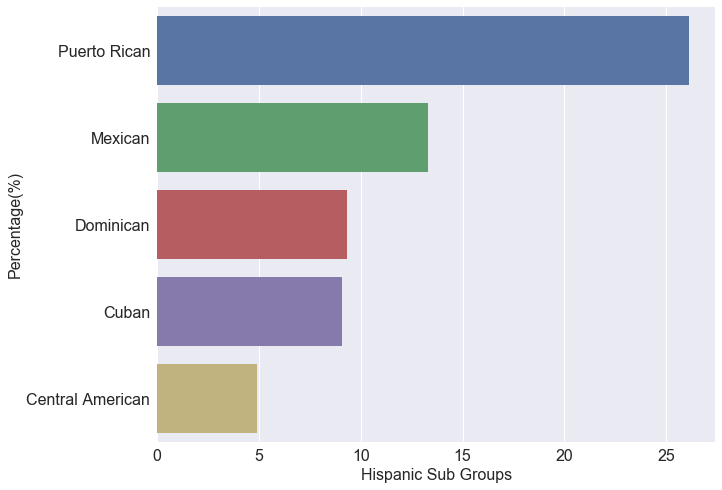

In [426]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(y = midtown_hispanic_pop['hispanic_subgroup'], x = midtown_hispanic_pop['Percent'])
ax.set_xlabel('Hispanic Sub Groups');
ax.set_ylabel('Percentage(%)');
plt.savefig('images/Hispanic Sub Groups Breakdown Midtown.png');

In [434]:
midtown_income = pd.read_csv('data/midtown_income.csv')

In [438]:
midtown_income = midtown_income.iloc[::-1]
midtown_income

,INCOME AND BENEFITS,Number,Percentage,Unnamed: 3
9,"$200,000 or more","4,513",28.3,NaN
8,"$150,000 to $199,999","1,778",11.2,NaN
7,"$100,000 to $149,999","2,390",15.0,NaN
6,"$75,000 to $99,999","1,119",7.0,NaN
5,"$50,000 to $74,999","1,107",6.9,NaN
4,"$35,000 to $49,999","1,165",7.3,NaN
3,"$25,000 to $34,999",766,4.8,NaN
2,"$15,000 to $24,999",927,5.8,NaN
1,"$10,000 to $14,999",797,5.0,NaN
0,"Less than $10,000","1,382",8.7,NaN


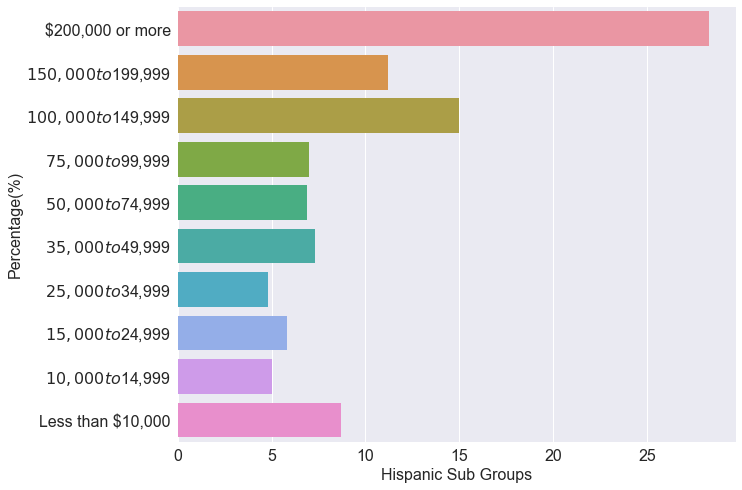

In [439]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(y = midtown_income['INCOME AND BENEFITS'], x = midtown_income['Percentage'])
ax.set_xlabel('Hispanic Sub Groups');
ax.set_ylabel('Percentage(%)');
#plt.savefig('images/Hispanic Sub Groups Breakdown Midtown.png');